# Filling Audio Gaps with VAR Model

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from IPython.display import Audio

## Loading Data

In [20]:
def scipy_spectrogram(audio, rate):
    frequencies, times, spectrogram = signal.stft(audio, rate)
    return spectrogram

In [43]:
music_sample_rate, music_wav = wavfile.read('data/chopin_waltz.wav')
music_wav = music_wav.astype(np.float32)
music_duration = music_wav.shape[0] / music_sample_rate
music_sample_duration = music_duration / music_wav.shape[0]

# convert two channel audio to mono
if len(music_wav.shape) > 1:
    music_wav = music_wav.mean(axis=1)

# parameters for spectrogram
window_size = 1024
hop_size = int(0.25*window_size)

In [42]:
# duration of each audio clip in seconds
music_duration

270.29189583333334

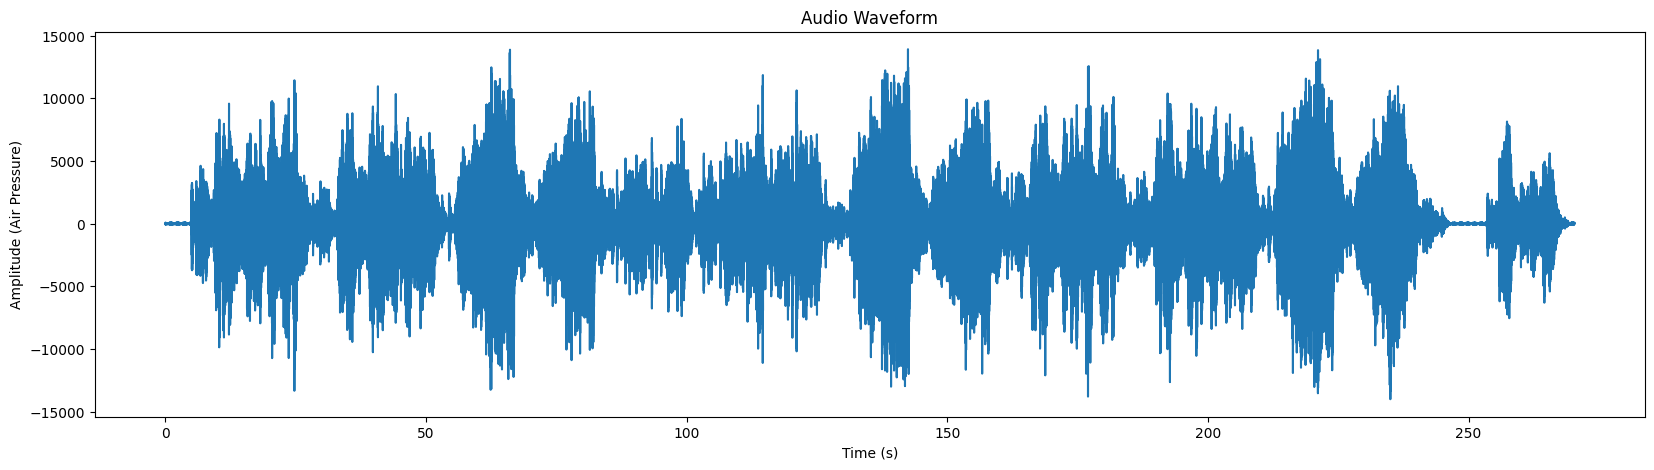

In [38]:
# plot music waveform
plt.figure(figsize=(20, 5))
plt.plot([x * music_sample_duration for x in range(music_wav.shape[0])], music_wav)
plt.title("Audio Waveform")
plt.ylabel("Amplitude (Air Pressure)")
plt.xlabel("Time (s)")
plt.show()

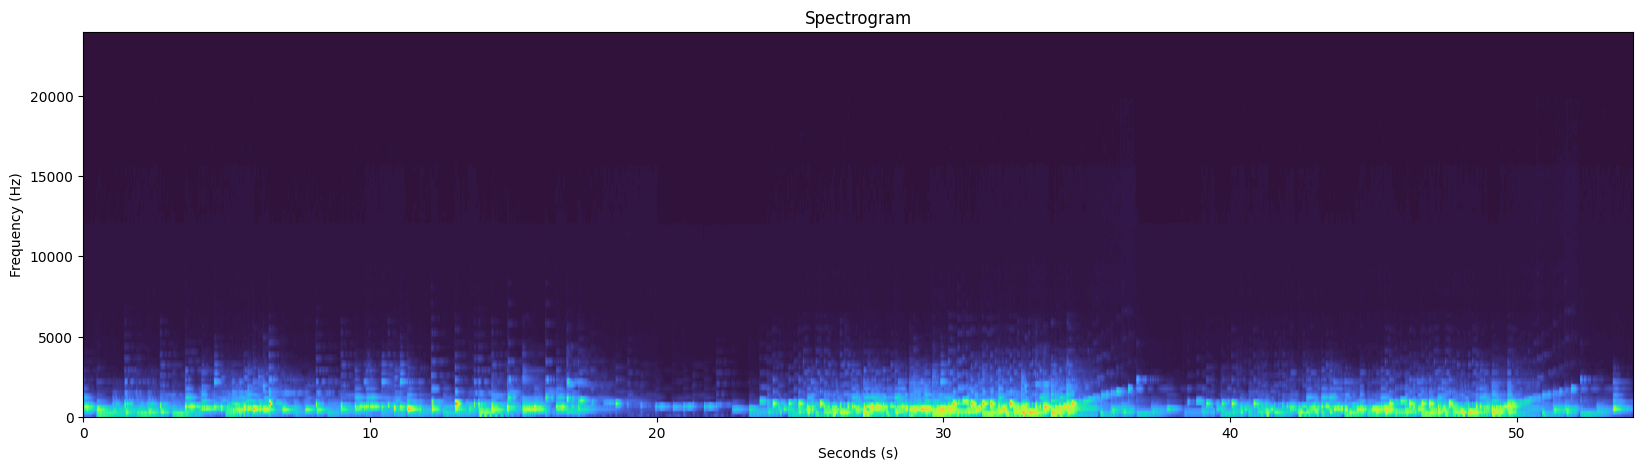

In [49]:
# grab middle of audio clip and visualize spectrogram
music_wav_seg = music_wav[int(0.4*music_wav.shape[0]):int(0.6*music_wav.shape[0])]
spec = scipy_spectrogram(music_wav_seg, music_sample_rate)
plt.figure(figsize=(20, 5))
plt.imshow(np.sqrt(np.abs(spec)), 
           cmap='turbo', origin='lower', aspect='auto',
           extent=[0, music_wav_seg.shape[0]*music_sample_duration, 
                   0, music_sample_rate/2])
plt.title("Spectrogram")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Seconds (s)")
plt.show()

## VAR Imputation

We train a VAR model on dataset of classical music to obtain a matrix $A$ that can be applied to predict the next element of a series of spectrogram frames given the past $N$ entries. This can then be used to impute missing frames in an audio clip's spectrogram.

### VAR Formulation

Given a time series of vectors $\mathbf{x}_1, \ldots, \mathbf{x}_K \in \mathbb{R}^d$, the VAR model looks to find matrices $A_1, A_2, \ldots, A_N \in \mathbb{R}^{d \times d}$ such that for at each time step $t$,
$$
    \mathbf{x}_t = A_1 \mathbf{x}_{t-1} + A_2 \mathbf{x}_{t-2} + \ldots + A_N \mathbf{x}_{t-N} + \epsilon
$$
where $\epsilon$ is an error term. (We can modify this later to consider future data points as well to predict the current vector).

We find these $A_i$ matrices for a single time series (looking to minimize the error $\epsilon$) as follows. First we construct a matrix $X \in \mathbb{R}^{dN \times (K-N)}$ ($K$ is the length of the sequence) where the $i$-th column is created by stacking the $\mathbf{x}_{i-1}$ through $\mathbf{x}_{i-N}$ (starting with $i = N$). We then stack all the $A_i$ matrices side by side to get a matrix $A \in \mathbb{R}^{d \times dN}$. Then performing the multiplication $Y = AX + \epsilon \in \mathbb{R}^{d \times (K-N)}$, the $t$-th column of $Y$ contains exactly the expression for $\mathbf{x}_t$ shown above for the VAR model, and thus it is the predicted $t$-th time step by the model. The $A$ that minimizes the prediction error in the least-squares sense can then be found as $A = Y X^{+}$ (setting $\epsilon = \mathbf{0}$), which is what we want.

Note that when using the past $N$ time points to predict the current, we can only predict from the $N$ time step (assuming 0-indexing) and onwards, since before that point there will not be $N$ data previous data points to use (alternatively we could make predictions here by setting the nonexistent previous points to 0).

In our case, we construct the matrix $X$ by taking a bunch of music clips and concatenating their spectrograms back to back. Our computed $A$ will then allow us to predict a frame in the spectrogram given the past $N$, which we can use to impute audio data.


In [7]:
def stack_past_N(series: np.ndarray, N: int) -> np.ndarray:
    """
    For every timestep, stack past N data points together

    Args:
        series: 2D [d x k] matrix representing time series. Each column is a time step.
        N: number of past data points to stack together

    Returns:
        2D [Nd x (k - N)] matrix where i-th column is a concatentaion the past N time steps (earlier time steps first/lower index)
    """
    d, k = series.shape
    stacked = np.empty((N*d + 1, k - N))
    for i in range(N):
        stacked[i*d:(i+1)*d, :] = series[:, i:k - N + i]
    # add row of 0s for bias term
    stacked[-1] = np.ones(k - N)
    return stacked

def train_VAR(series: np.ndarray, N: int) -> np.ndarray:
    """
    Train a VAR model on the given time series using N lags.

    Arg:
        series: 2D [d x k] matrix representing time series. Each column is a time step
        N: number of lags to use in VAR model
    
    Returns:
        2D [d x (dN + 1)] matrix representing the weights of the VAR model inluding bias
    """
    stacked_data = stack_past_N(series, N)
    return series @ np.linalg.pinv(stacked_data)